This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch lecture, seminar, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU) at 15:30 or in [here](https://habrahabr.ru/post/275429/) but in 2D. You can google, search code at github, whatever, but the network should be based on Theano. 

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver`). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, render your animation to video (`.mp4`) or to `.webm` format. `.gif` typically is very heavy in size.

And make sure your code works if 'Run All' is pressed and it draws the animation you've rendered.

Good luck!

In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use('gpu0')

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX TITAN X (0000:04:00.0)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.utils import floatX
from IPython import display
import seaborn as sns
%matplotlib inline

### Functions to genearate samples and noise

In [3]:
def samples(batch_size):
    k = np.random.binomial(batch_size, 0.5, 1)
    X1 = np.random.multivariate_normal([0., 0.], [[25., 0], [0, 1]], k)
    X2 = np.random.multivariate_normal([0., 0.], [[1., 0], [0, 25.]], batch_size - k)
    return np.vstack([X1, X2])

In [4]:
def noise(batch_size):
    X = np.random.multivariate_normal([0., 0], [[1., 0], [0, 1]], batch_size)
    return X

### Generative network

In [5]:
G = {}
G_input = T.matrix()
G['input'] = lasagne.layers.InputLayer((None, 2), G_input)
G['dense1'] = lasagne.layers.DenseLayer(G['input'], 15, 
                                        nonlinearity=lasagne.nonlinearities.rectify)
G['dense2'] = lasagne.layers.DenseLayer(G['dense1'], 15, 
                                        nonlinearity=lasagne.nonlinearities.rectify)
G['output'] = lasagne.layers.DenseLayer(G['dense2'], 2, nonlinearity=None)
G_out = lasagne.layers.get_output(G['output'])

### Discriminator network

In [6]:
D = {}
D_input = T.matrix()
D['input'] = lasagne.layers.InputLayer((None, 2), D_input)
D['dense1'] = lasagne.layers.DenseLayer(D['input'], 15, 
                                        nonlinearity=lasagne.nonlinearities.tanh)
D['dense2'] = lasagne.layers.DenseLayer(D['dense1'], 15, nonlinearity=
                                        lasagne.nonlinearities.tanh)
D['output'] = lasagne.layers.DenseLayer(D['dense2'], 1, 
                                        nonlinearity=lasagne.nonlinearities.sigmoid)

In [7]:
real_out = lasagne.layers.get_output(D['output'], {D['input']: D_input})
fake_out = lasagne.layers.get_output(D['output'], {D['input']: G_out})

### Output functions

In [8]:
discriminate = theano.function([D_input], real_out)
generate = theano.function([G_input], G_out)

### Objectives

In [9]:
G_obj = (T.log(fake_out)).mean()
D_obj = (T.log(real_out) + T.log(1 - fake_out)).mean()

In [10]:
G_params = lasagne.layers.get_all_params(G['output'], trainable=True)
G_lr = theano.shared(np.array(1e-3, dtype=theano.config.floatX))
G_updates = lasagne.updates.adam(1 - G_obj, G_params, learning_rate=G_lr)
G_train = theano.function([G_input], G_obj, updates=G_updates)

D_params = lasagne.layers.get_all_params(D['output'], trainable=True)
D_lr = theano.shared(np.array(1e-2, dtype=theano.config.floatX))
D_updates = lasagne.updates.adam(1 - D_obj, D_params, learning_rate=D_lr)
D_train = theano.function([G_input, D_input], D_obj, updates=D_updates)

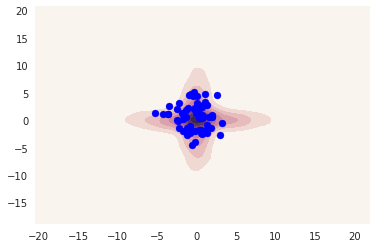

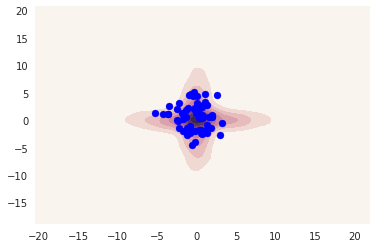

In [11]:
batch_size = 64
epochs = 500
k = 10

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

samples_to_plot = samples(5000)
pic = 1

for i in range(epochs):
    for j in range(k):
        X = floatX(samples(batch_size))  # sampled m-batch from p_data
        Z = floatX(noise(batch_size))  # sample m-batch from noise prior
        D_train(Z, X)
    Z = floatX(noise(batch_size))
    G_train(Z)
    if i % 10 == 0:
        G_lr *= 0.999
        D_lr *= 0.999
    if i % 40 == 0:
        batch_to_plot = generate(Z)
        sns.kdeplot(samples_to_plot[:, 0], samples_to_plot[:, 1], cmap=cmap, shade=True)    
        plt.scatter(batch_to_plot[:, 0], batch_to_plot[:, 1], c='b')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.savefig('pic_%02d.jpg' % pic)
        pic += 1 

In [ ]:
!convert -delay 35 pic_*.jpg anim.gif